In [ ]:
import os
from pathlib import Path
import logging
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import (Dataset, DataLoader)
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    AdamW,
    get_linear_schedule_with_warmup
)

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST
)

sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
device = "cuda" if torch.cuda.is_available() else "cpu"

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

: 

In [ ]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

: 

In [ ]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

: 

In [ ]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
dev.reset_index(drop=True, inplace=True)
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
test.reset_index(drop=True, inplace=True)
Y_test = test[features.mlb.classes_].copy()

: 

In [ ]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_dev.sum(axis=0).plot.bar(ax=ax[0])
Y_test.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Development")
ax[1].set_title("Test");

: 

In [ ]:
train, val, _, _ = train_test_split(
    dev, dev[features.mlb.classes_].to_numpy(), test_size=.1, shuffle=True, random_state=64
)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

Y_train = train[features.mlb.classes_].copy()
Y_val = val[features.mlb.classes_].copy()

: 

In [ ]:
# plt.figure(figsize=(6, 3))
fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
Y_train.sum(axis=0).plot.bar(ax=ax[0])
Y_val.sum(axis=0).plot.bar(ax=ax[1])
ax[0].set_title("Train") 
ax[1].set_title("Val");

: 

In [ ]:
class JJDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        features: Features,
        tokenizer: AutoTokenizer,
        max_length: int = 128
    ):
        self.df = df
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]
        text = row[ORIGINAL_TEXT]
        target = row[self.features.mlb.classes_]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "token_type_ids": inputs["token_type_ids"].flatten(),
            "target": torch.FloatTensor(target)
        }

: 

In [ ]:
class Model(nn.Module):
    def __init__(self, transformer):
        super().__init__()
        self.l1 = transformer
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, len(features.mlb.classes_))

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out[0][:, -1, :])
        out = self.l3(out)
        return out

: 

In [ ]:
MODEL_NAME = 'gpt2-medium'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

transformer_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=MODEL_NAME)
transformer = AutoModel.from_pretrained(pretrained_model_name_or_path=MODEL_NAME, config=transformer_config)
transformer.resize_token_embeddings(len(tokenizer))
transformer.config.pad_token_id = transformer.config.eos_token_id

: 

In [ ]:
plt.figure(figsize=(4,3))
token_counts = []
for _, row in train.iterrows():
    tokens = tokenizer.encode(
        row[ORIGINAL_TEXT],
        max_length=512,
        truncation=True
    )
    token_counts.append(len(tokens))

sns.histplot(token_counts)
plt.xlabel("# Tokens")
plt.ylabel("# Regulations")
plt.xlim([0, 512]);

: 

In [ ]:
MAX_TOKEN_COUNT = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
NUM_WORKERS = 0

train_dataset = JJDataset(
    df=train,
    features=features,
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_COUNT
)
valid_dataset = JJDataset(
    df=val,
    features=features,
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_COUNT
)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKERS)

: 

In [ ]:
EPOCHS = 15
LEARNING_RATE = 5e-5
TOTAL_STEPS = len(train_loader) * EPOCHS

model = Model(transformer=transformer)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=TOTAL_STEPS)

saved_models_path = os.path.join(data.current_path, "saved_models")

: 

In [14]:
# Move model to device
model.to(device)
# Lists to keep the losses and evaluation scores at the end of each epoch
train_loss, valid_loss = list(), list()
for epoch in range(EPOCHS):
    # Dummy lists to keep the losses and evaluation scores at the end of each iteration
    # (one batch forward and backward process)
    train_batch_loss, valid_batch_loss = list(), list()
    # Training mode
    model.train()
    for i, item in enumerate(train_loader):
        # Move input to device
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)
        # Forward pass
        out = model(input_ids, attention_mask, token_type_ids)
        # Calculate loss
        loss = criterion(out, target)
        # Reset gradients
        optimizer.zero_grad()
        # Backward pass (backpropogation)
        loss.backward()
        # Prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update weights
        optimizer.step()
        # Scheduler step
        scheduler.step()
        # Collect loss and evaluation scores
        train_batch_loss.append(loss.item())
        message = \
            f"EPOCH:{epoch+1}/{EPOCHS}, " + \
            f"step:{i+1}/{len(train_loader)}, " + \
            f"loss={loss.item()}"
        print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    train_loss.append(np.array(train_batch_loss).mean())
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, item in enumerate(valid_loader):
            # Move input to device
            input_ids = item["input_ids"].to(device, dtype=torch.long)
            attention_mask = item["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
            target = item["target"].to(device, dtype=torch.float)
            # Forward pass
            out = model(input_ids, attention_mask, token_type_ids)
            # Calculate loss
            loss = criterion(out, target)
            valid_batch_loss.append(loss.item())
            message = \
                f"EPOCH:{epoch+1}/{EPOCHS}, " + \
                f"step:{i+1}/{len(valid_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    valid_loss.append(np.array(valid_batch_loss).mean())
    message = \
        f"EPOCH:{epoch+1}/{EPOCHS} - " + \
        f"Training Loss: {train_loss[-1]}, " + \
        f"Validation Loss: {valid_loss[-1]}"
    print("\r", message)
    # Save model
    state = f"epoch_{epoch+1:03}.pth"
    state_dict_path = os.path.join(saved_models_path, state)
    torch.save(model.state_dict(), state_dict_path)


 EPOCH:1/50 - Training Loss: 0.1804978081898898, Validation Loss: 0.13436993117305054
 EPOCH:2/50 - Training Loss: 0.12225784467216388, Validation Loss: 0.09232506125994112
 EPOCH:3/50 - Training Loss: 0.0815999687507691, Validation Loss: 0.06888677110231814
 EPOCH:4/50 - Training Loss: 0.05750787112869073, Validation Loss: 0.05852328695292617
 EPOCH:5/50 - Training Loss: 0.04282136333172603, Validation Loss: 0.0523328513667073
 EPOCH:6/50 - Training Loss: 0.03362419880049294, Validation Loss: 0.059249678682857035


RuntimeError: [enforce fail at inline_container.cc:325] . unexpected pos 501927040 vs 501926932

: 

In [17]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();

Best epoch: 8


ValueError: x and y must have same first dimension, but have shapes (30,) and (10,)

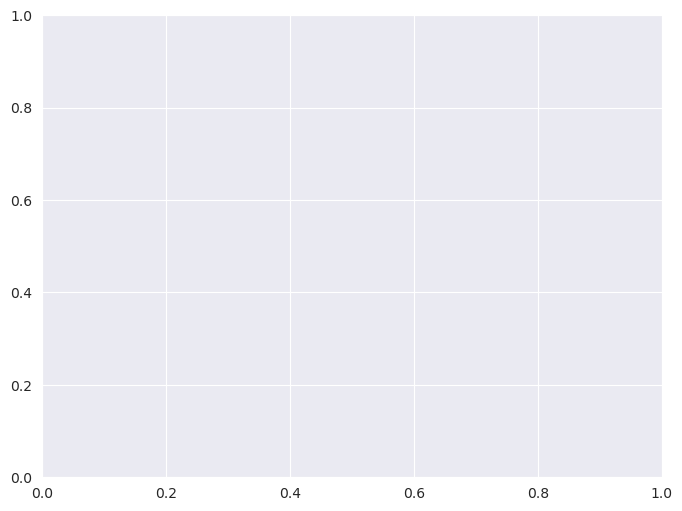

In [18]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss", color="orange")
plt.plot(range(1, EPOCHS+1), valid_loss, label="Validation Loss", color="blue")
plt.axvline(x=best_epoch, label="Best Epoch", color="darkgreen", linestyle="dashdot")
plt.xlabel("Epoch")
plt.ylabel(f"Loss")
plt.title(f"Best Epoch: {best_epoch}")
plt.legend(loc="upper right");

In [20]:
valid_dataset = JJDataset(
    df=val,
    features=features,
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_COUNT
)

valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(valid_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

In [21]:
y_true_val = np.array(y_true).astype(int)
y_pred_probab_val = np.array(y_pred_probab)

In [22]:
eval = CustomEvaluation()

In [23]:
thresholds = eval.threshold_discovery(y_true_val, y_pred_probab_val)

In [24]:
y_pred_val = np.where(y_pred_probab_val > thresholds, 1, 0)

eval.compute_sample_wise_metrics(y_true=y_true_val, y_pred=y_pred_val)

Hamming Loss    0.014783
Accuracy        0.643478
Precision       0.818371
Recall          0.861643
F1 Score        0.818312
F2 Score        0.837113
dtype: float64

In [25]:
eval.compute_sample_wise_metrics(y_true=y_true_val, y_pred=np.where(y_pred_probab_val > .5, 1, 0))

Hamming Loss    0.015217
Accuracy        0.657971
Precision       0.809213
Recall          0.772995
F1 Score        0.776293
F2 Score        0.771464
dtype: float64

In [26]:
test_dataset = JJDataset(
    df=test,
    features=features,
    tokenizer=tokenizer,
    max_length=MAX_TOKEN_COUNT
)

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(test_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

In [27]:
y_true_test = np.array(y_true).astype(int)
y_pred_probab_test = np.array(y_pred_probab)
y_pred_test = np.where(y_pred_probab_test > thresholds, 1, 0)

In [28]:
eval.compute_sample_wise_metrics(y_true=y_true_test, y_pred=y_pred_test)

Hamming Loss    0.017839
Accuracy        0.601562
Precision       0.786285
Recall          0.852378
F1 Score        0.791794
F2 Score        0.818155
dtype: float64

In [29]:
eval.compute_sample_wise_metrics(y_true=y_true_test, y_pred=np.where(y_pred_probab_test > .5, 1, 0))

Hamming Loss    0.014583
Accuracy        0.671875
Precision       0.812500
Recall          0.803029
F1 Score        0.790828
F2 Score        0.793571
dtype: float64

In [28]:
eval.compute_label_wise_metrics(
    y_true=y_true_test,
    y_pred=y_pred_test,
    labels=features.mlb.classes_,
    dev_samples=Y_dev.to_numpy().sum(axis=0).tolist()
)

,Precision,Recall,F1 Score,F2 Score,Development Samples,Test Samples
audit inspection,0.800000,0.888889,0.842105,0.869565,86,9
calibration,0.800000,0.666667,0.727273,0.689655,78,6
capa,0.760000,0.950000,0.844444,0.904762,202,20
change controls,0.666667,0.888889,0.761905,0.833333,71,9
clinical research,0.931034,0.931034,0.931034,0.931034,269,29
controled substances,1.000000,0.833333,0.909091,0.862069,40,6
csv,0.250000,0.333333,0.285714,0.312500,37,3
data management,0.722222,1.000000,0.838710,0.928571,150,13
design controls,0.692308,0.818182,0.750000,0.789474,132,11
documentation management,0.833333,0.769231,0.800000,0.781250,117,13
